In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
df_ab = pd.read_csv('ptbdb_abnormal.csv', header = None)
df_no = pd.read_csv('ptbdb_normal.csv', header=None)

In [3]:
ab_ = df_ab.values[:, :187]
no_ = df_no.values[:, :187]

In [13]:
print(len(ab_), len(no_))

10506 4046


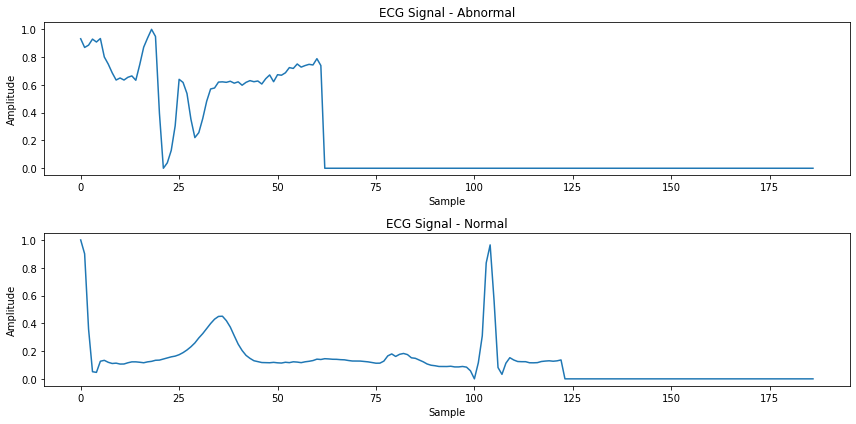

In [4]:
#Visualize one signal from both classes
sample_ab = ab_[0]
sample_no = no_[0]
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)  # Subplot 1
plt.plot(sample_ab)
plt.title('ECG Signal - Abnormal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)  # Subplot 2
plt.plot(sample_no)
plt.title('ECG Signal - Normal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

<Figure size 1080x720 with 0 Axes>

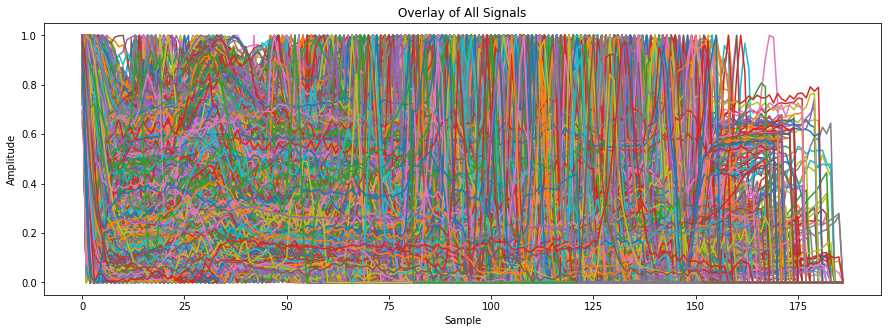

In [8]:
plt.figure(figsize=(15, 10))

plt.figure(figsize=(15, 5))

for i in range(len(ab_)):
    plt.plot(ab_[i], label=f'Signal {i+1}')

plt.title('Overlay of All Signals')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
#plt.legend()
plt.show()

<Figure size 1080x720 with 0 Axes>

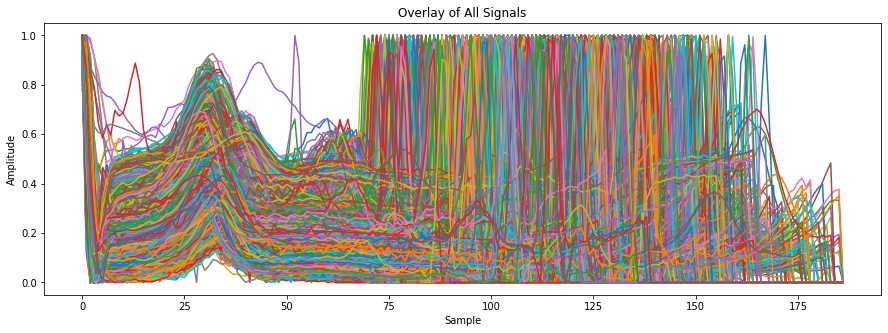

In [9]:
plt.figure(figsize=(15, 10))

plt.figure(figsize=(15, 5))

for i in range(len(no_)):
    plt.plot(no_[i], label=f'Signal {i+1}')

plt.title('Overlay of All Signals')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
#plt.legend()
plt.show()

In [29]:
df = pd.concat([df_ab.iloc[:, 0:5000],df_no], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [30]:
X = df.iloc[:, :187].values
y = df.iloc[:, -1].values

# Convert labels to binary (0 for normal, 1 for abnormal)
y_binary = torch.LongTensor(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Standardize the features (mean=0, std=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)

# Convert labels to PyTorch tensors
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)



In [31]:
# Define the CNN model
class ECGCNN(nn.Module):
    def __init__(self):
        super(ECGCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 92, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 2)  # Output layer with 2 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model
model = ECGCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [32]:
# Train the model
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    for i in range(0, len(train_dataset), batch_size):
        inputs, labels = train_dataset[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))  # Add a channel dimension
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    average_loss = total_loss / (len(train_dataset) / batch_size)
    accuracy = correct_predictions / len(train_dataset)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor.unsqueeze(1))
    predicted = torch.argmax(outputs, dim=1)
    accuracy = (predicted == y_test_tensor).float().mean().item()

print(f'Test Accuracy: {accuracy}')

Epoch 1/10, Loss: 0.4151, Accuracy: 0.7895
Epoch 2/10, Loss: 0.3506, Accuracy: 0.8348
Epoch 3/10, Loss: 0.3038, Accuracy: 0.8630
Epoch 4/10, Loss: 0.2797, Accuracy: 0.8804
Epoch 5/10, Loss: 0.2404, Accuracy: 0.9023
Epoch 6/10, Loss: 0.2291, Accuracy: 0.9059
Epoch 7/10, Loss: 0.2049, Accuracy: 0.9232
Epoch 8/10, Loss: 0.1936, Accuracy: 0.9250
Epoch 9/10, Loss: 0.1791, Accuracy: 0.9328
Epoch 10/10, Loss: 0.1665, Accuracy: 0.9344
Test Accuracy: 0.9594640731811523
